## Importing Libraries

In [54]:
import pandas as pd
import json
import os
import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [55]:
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/riccardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/riccardo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/riccardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading and Pre-Processing

In [56]:
pd.set_option("max_colwidth", None)
plt.style.use("ggplot")

Loading environmental variable in order to not show the path to the file

In [57]:
load_dotenv()
path = os.getenv('FILE_PATH')

This function is useful in order to load the json file, create a dataframe starting from a list of dictionaries containing titles, bodies and ratings.

In [58]:
def creating_ds():
    with open(str(path), 'r') as json_file:
        data = json.load(json_file)
    
    reviews = {"Title": [], "Content": [], "Stars": [], "Verified": [], "Date": []}

    for page in data:
        if len(page) != 0: # check if page is not empty -> if there are reviews
            for i in range(len(page['Body'])):
                reviews['Title'].append(page['Title'][i].strip().lower())
                reviews['Content'].append(page['Body'][i].strip().lower())
                reviews['Stars'].append(page['Stars'][i][:1])
                reviews['Verified'].append(page['Verified'][i].strip().lower())
                reviews['Date'].append(page['Date'][i].strip())
    
    reviews = pd.DataFrame.from_dict(reviews)
    return reviews

In [59]:
df = creating_ds()
df.head()

,Title,Content,Stars,Verified,Date
0,"very comfortable, responsive, very quiet (tho not completely silent)","i've been having trouble with my bluetooth mouse lately. it takes a while to connect, and drops connection every time my laptop goes to sleep.\n\ni figured it's time to revert back to a usb mouse that, even though it does take up a usb port, at least is consistently reliable.\n\nthis one does not fail. responsiveness is perfect, and the left and right buttons don't take much to activate.\n\ni especially love the flattened shape of the mouse. the footprint of it is the size of a standard, full sized mouse, but the overall shape is flatter. this means that my hand and fingers curve over it flatter rather than curled. to me, it just feels more natural and comfortable.\n\ni am a 5'4"" woman, but my 6'2"" husband has tried it too. he said it initially felt a bit odd. he said it felt like his entire hand covered it, but after using it for several days, he asked me to order one for him too.\n\nif you're gaming, heavy into graphic arts or needing a mouse with a lot of options, this may not be for you. but, for ordinary office and personal use, we are very happy with this.\n\nthe price is fantastic and the fact that it even comes with a battery is unheard of.",5,verified purchase,"Reviewed in the United States on September 28, 2023"
1,it's a simple mouse. it works well!,nothing to complain. mouse works.,5,verified purchase,"Reviewed in the United States on December 8, 2023"
2,"lenovo 530. wireless computer mouse for pc, laptop. large and comfortable. no sticky plastic.","the ""lenovo 530 wireless mouse"" is a good option for a wireless mouse that is both affordable and reliable.\n\nit has a 2.4 ghz wireless connection that is strong and consistent, and it also has a long battery life of up to 12 months. the mouse is ambidextrous, so it can be used by both left-handed and right-handed users.\n\nit's full sized and is a basic three-button mouse with a wheel.\n\nno extra side buttons to get in the way or sticky soft plastic that is hard to keep clean.\n\npros:\n\naffordable\nlong battery life\nambidextrous design\n2.4 ghz wireless connection\nsimple and basic with no extra buttons or unusual shape\ncomfortable to use for those with larger hands.\n\ncons:\n\nthe scroll wheel can be a bit stiff.\nmay be too large for smaller hands\ntakes up more space for travel or portable users\nsmall usb dongle is needed to use and can be lost, misplaced, or forgotten.\n\noverall, the lenovo 530 wireless mouse is a good option for a wireless mouse that is both affordable and reliable. it is a good choice for both home and office use.",5,verified purchase,"Reviewed in the United States on August 17, 2023"
3,not as good as past mouse... but ok.,"got this because i usually love lenovo keyboards and their mouse. but this one was a little ""fat"" and not great with batteries. but still pretty good. will look for a different kind when this one dies.",5,verified purchase,"Reviewed in the United States on October 31, 2023"
4,great product,like everything about it.,4,verified purchase,"Reviewed in the United States on November 16, 2023"


In [60]:
df.isna().sum() # checking for null values

Title       0
Content     0
Stars       0
Verified    0
Date        0
dtype: int64

In [61]:
df['Verified'].value_counts() # checking for unique values

Verified
verified purchase    100
Name: count, dtype: int64

I was thinking on plotting something about verified purchases but in this case they are all verified so any type of plot would be useless

### Text adjustments

In [62]:
# Removing special characters
def clean(content):
    content = re.sub('\W+',' ', content )                             # special characters
    content = re.sub(r'[:;=]\s*[-]?[)D(\[\]/\\OpP]', '', content)     # emoticons
    content = re.sub(r'[^\w\s]', '', content)                         # punctuation
    return content

def remove_url(content): # removing urls
    return re.sub(r'http\S+', '', content)

# Data preprocessing
def data_cleaning(content):
    content = remove_url(content)
    content = clean(content)   
    return content

In [63]:
def parse_date(date):
    words = date.split()

    # Find the index of the word "on"
    try:
        index_of_on = words.index('on')
    except ValueError:
        # If 'on' is not found, return the original string
        return date

    # Extract the date information starting from the word after "on"
    date_string = ' '.join(words[index_of_on + 1:])
    date_obj = datetime.datetime.strptime(date_string, '%B %d, %Y')
    formatted_date = date_obj.strftime('%Y-%m-%d')
    return formatted_date

In [64]:
def divide_date(date):
    year, month, day = map(int, date.split('-'))
    return year, month, day

In [65]:
df['Clean Review'] = df['Title'] + ' ' + df['Content']
df['Clean Review'] = df['Clean Review'].apply(data_cleaning)
df['Date'] = df['Date'].apply(parse_date)
df['Year'], df['Month'], df['Day'] = zip(*df['Date'].apply(divide_date))

Here I calculate the sentiment only based on the star the user gave to the product

In [66]:
def calculate_sentiment_from_stars(stars):
    if stars == '5' or stars == '4':
        sentiment = 'Positive'
    elif stars == '3':
        sentiment = 'Neutral'
    elif stars == '2' or stars == '1':
        sentiment = 'Negative'
    return sentiment

In [67]:
df['Sentiment from Stars'] = df['Stars'].apply(calculate_sentiment_from_stars)

Now I want to rearrange the text of the column 'Clean Review'. First of all I removed all the **stopwords** from the text. Stopwords are all the words that don't give a notable meaning to the text, so in order to calculate the sentiment of a text they are not useful and they can lead to a missclassification.

In [68]:
def remove_stopwords(content):
    words = nltk.word_tokenize(content)
    return ' '.join([word for word in words if word not in stopwords.words('english')])

In [69]:
df['Clean Review'] = df['Clean Review'].apply(remove_stopwords)

## EDA and Plots

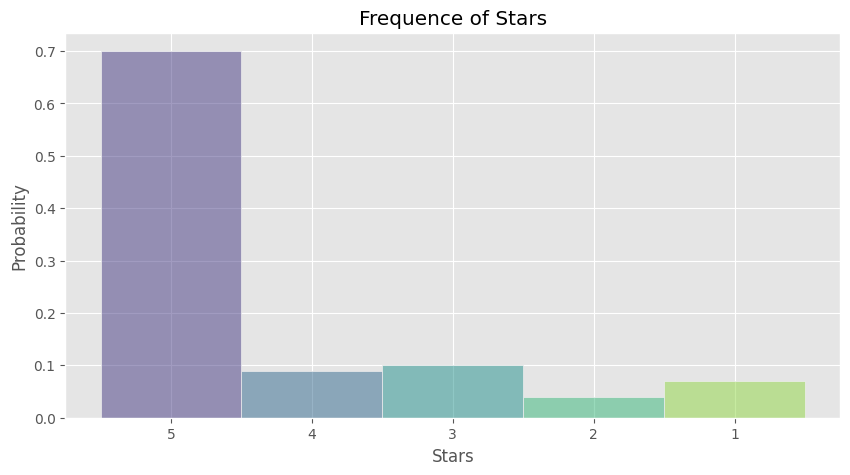

In [70]:
plt.figure(figsize=(10, 5))
sns.histplot(x=df['Stars'], bins=len(df['Stars'].unique()), kde=False, palette='viridis', hue=df['Stars'], stat='probability', legend=False)

# Add labels and title
plt.xlabel('Stars')
plt.title('Frequence of Stars')

# Show the plot
plt.show()

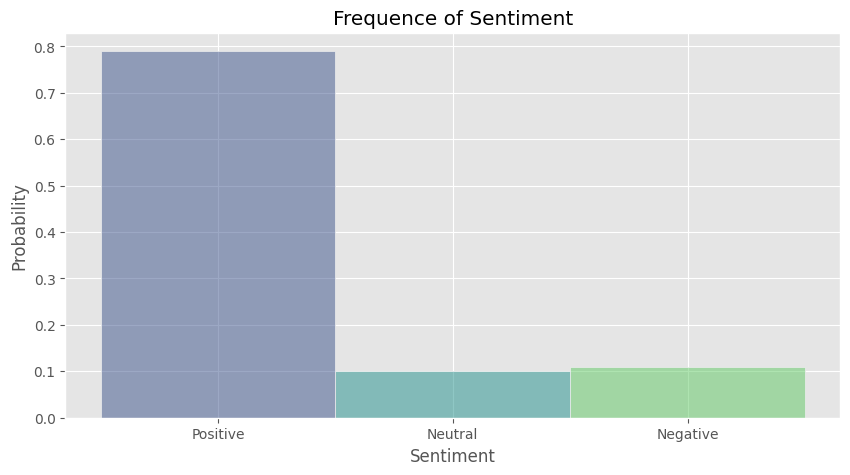

In [71]:
plt.figure(figsize=(10, 5))
sns.histplot(x=df['Sentiment from Stars'], bins=len(df['Sentiment from Stars'].unique()), kde=False, palette='viridis', hue=df['Sentiment from Stars'], stat='probability', legend=False)

# Add labels and title
plt.xlabel('Sentiment')
plt.title('Frequence of Sentiment')

# Show the plot
plt.show()

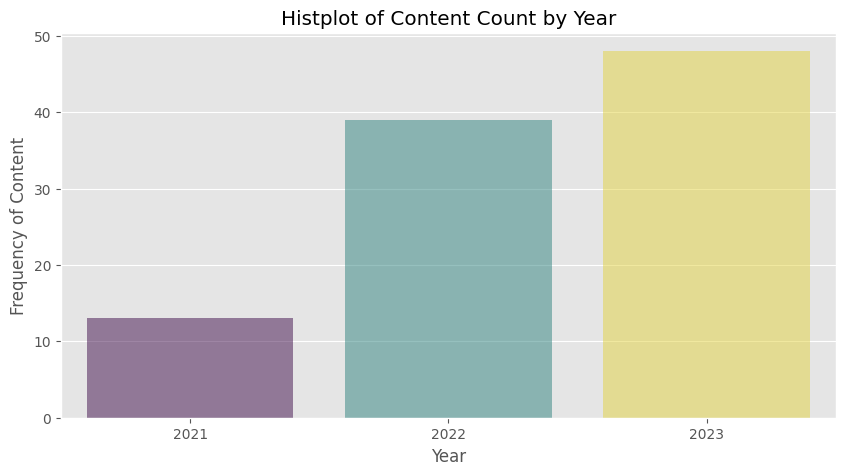

In [72]:
year_group = pd.DataFrame(df.groupby('Year')['Content'].count().reset_index(name='Count'))
plt.figure(figsize=(10, 5))
sns.barplot(data=year_group, x='Year', y='Count', palette='viridis', legend=False, hue='Year', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency of Content')
plt.title('Histplot of Content Count by Year')

# Show the plot
plt.show()

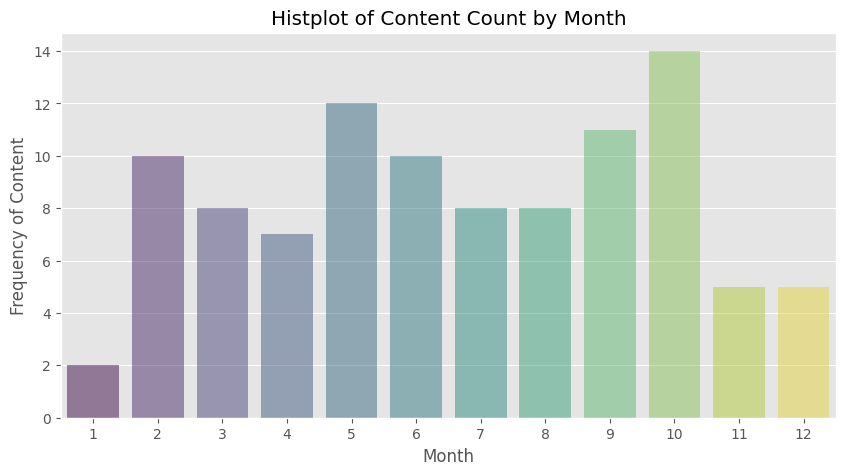

In [73]:
month_group = pd.DataFrame(df.groupby('Month')['Content'].count().reset_index(name='Count'))
plt.figure(figsize=(10, 5))
sns.barplot(data=month_group, x='Month', y='Count', palette='viridis', legend=False, hue='Month', alpha=0.5)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Frequency of Content')
plt.title('Histplot of Content Count by Month')

# Show the plot
plt.show()

In [74]:
def count_words(content):
    return len(content.split())

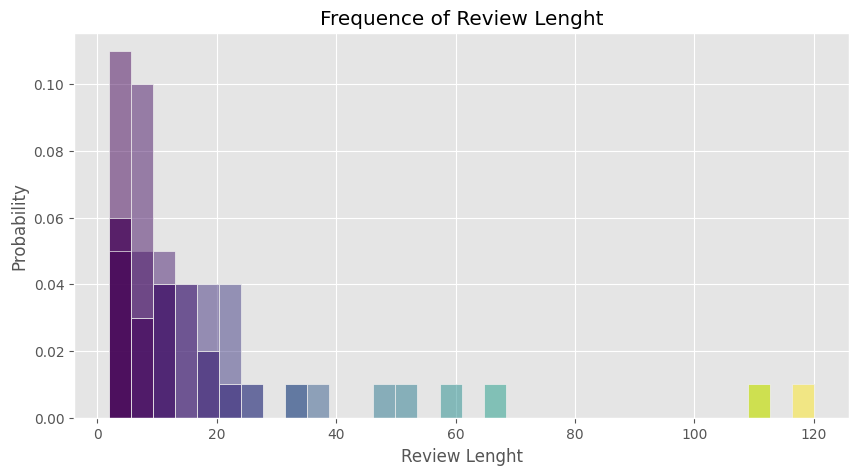

In [75]:
review_lenght = df['Clean Review'].apply(count_words)

plt.figure(figsize=(10, 5))
sns.histplot(x=review_lenght, bins=len(review_lenght.unique()), kde=False, palette='viridis', hue=review_lenght, stat='probability', legend=False)

# Add labels and title
plt.xlabel('Review Lenght')
plt.title('Frequence of Review Lenght')

# Show the plot
plt.show()

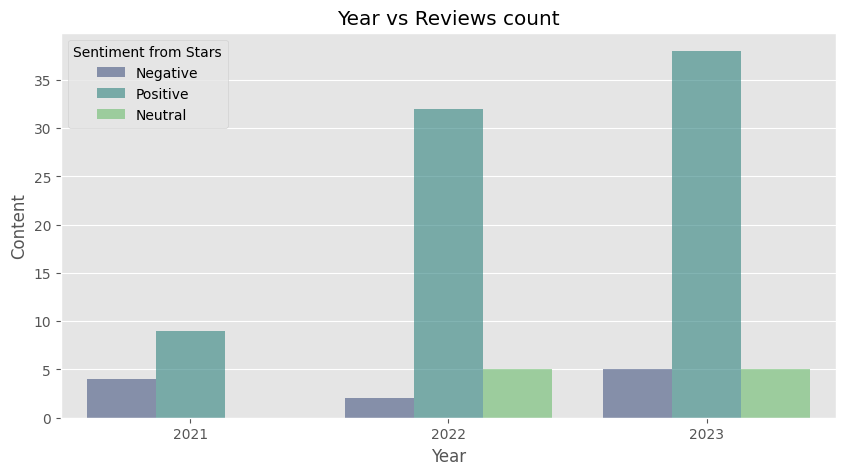

In [76]:
plt.figure(figsize=(10, 5))
Year = pd.DataFrame(df.groupby(['Year', 'Sentiment from Stars'])['Content'].count()).reset_index()

sns.barplot(x="Year", y="Content", hue='Sentiment from Stars', data=Year, palette='viridis', alpha=0.6)

# Add labels and title
plt.title('Year vs Reviews count')
plt.xlabel('Year')

# Show the plot
plt.show()

In [77]:
pos_reviews = " ".join(df[df['Sentiment from Stars'] == 'Positive']['Clean Review'])

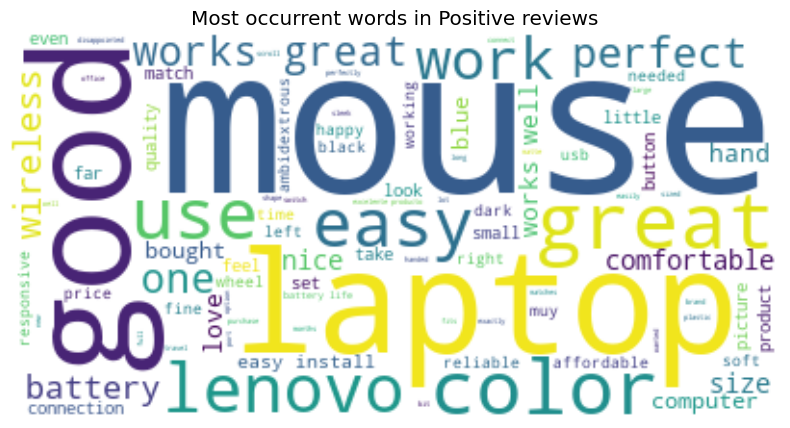

In [78]:
# generate and plot wordcloud for positive reviews
wordcloud = WordCloud(background_color="white", max_words=len(pos_reviews))
wordcloud.generate(pos_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Positive reviews")
plt.show()

In [79]:
neu_reviews = " ".join(df[df['Sentiment from Stars'] == 'Neutral']['Clean Review'])

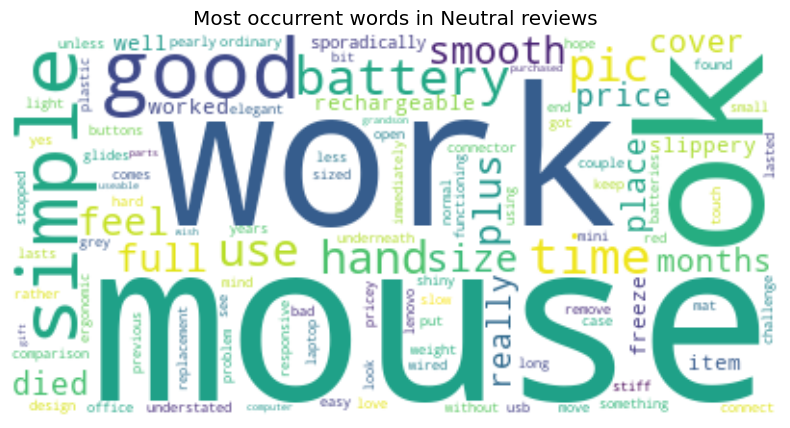

In [80]:
# generate and plot wordcloud for neutral reviews
wordcloud = WordCloud(background_color="white", max_words=len(neu_reviews))
wordcloud.generate(neu_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Neutral reviews")
plt.show()

In [81]:
neg_reviews = " ".join(df[df['Sentiment from Stars'] == 'Negative']['Clean Review'])

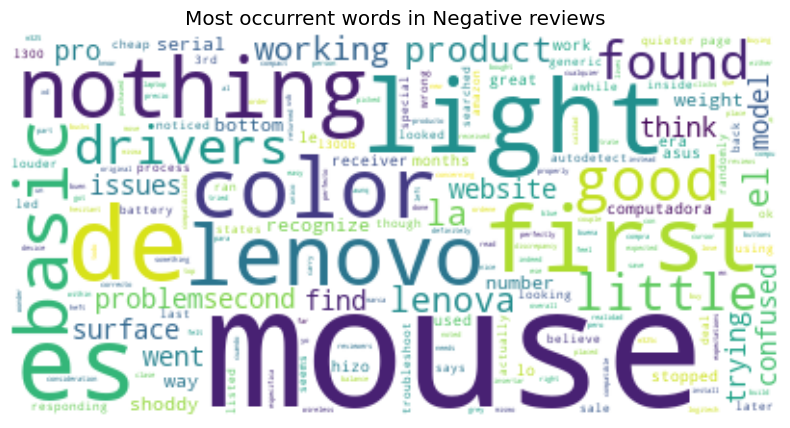

In [82]:
# generate and plot wordcloud for neutral reviews
wordcloud = WordCloud(background_color="white", max_words=len(neg_reviews))
wordcloud.generate(neg_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Negative reviews")
plt.show()

## Data Modelling

In [83]:
def lemmatize(content):
    words = word_tokenize(content)
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, wordnet.VERB) for word in words])

df['Clean Review'] = df['Clean Review'].apply(lemmatize)

Calculate the sentiment only based on the stars the user give to the product can be inconsistent, since for someone 3 stars have a meaning while for someone else they have another meaning. In order to avoid all the process of machine learning to be less precise and based on a fragile calculation I decided to calculate the sentiment using other models.

### VADER

VADER is a pre-built, rule-based sentiment analysis tool that is specifically designed for social media text. It assigns a polarity score to each word and combines them to generate an overall sentiment score.

In [84]:
def sentiment_vader(content):
    sid = SentimentIntensityAnalyzer()
    score = sid.polarity_scores(content)
    return score['pos'], score['neu'], score['neg'], score['compound']

In [85]:
df['VADER scores'] = df['Clean Review'].apply(sentiment_vader)
df[['VADER positive', 'VADER neutral', 'VADER negative', 'VADER compound']] = pd.DataFrame(df['VADER scores'].tolist(), index=df.index)
df = df.drop(columns=['VADER scores'])

In [86]:
df.head()

,Title,Content,Stars,Verified,Date,Clean Review,Year,Month,Day,Sentiment from Stars,VADER positive,VADER neutral,VADER negative,VADER compound
0,"very comfortable, responsive, very quiet (tho not completely silent)","i've been having trouble with my bluetooth mouse lately. it takes a while to connect, and drops connection every time my laptop goes to sleep.\n\ni figured it's time to revert back to a usb mouse that, even though it does take up a usb port, at least is consistently reliable.\n\nthis one does not fail. responsiveness is perfect, and the left and right buttons don't take much to activate.\n\ni especially love the flattened shape of the mouse. the footprint of it is the size of a standard, full sized mouse, but the overall shape is flatter. this means that my hand and fingers curve over it flatter rather than curled. to me, it just feels more natural and comfortable.\n\ni am a 5'4"" woman, but my 6'2"" husband has tried it too. he said it initially felt a bit odd. he said it felt like his entire hand covered it, but after using it for several days, he asked me to order one for him too.\n\nif you're gaming, heavy into graphic arts or needing a mouse with a lot of options, this may not be for you. but, for ordinary office and personal use, we are very happy with this.\n\nthe price is fantastic and the fact that it even comes with a battery is unheard of.",5,verified purchase,2023-09-28,comfortable responsive quiet tho completely silent trouble bluetooth mouse lately take connect drop connection every time laptop go sleep figure time revert back usb mouse even though take usb port least consistently reliable one fail responsiveness perfect leave right button take much activate especially love flatten shape mouse footprint size standard full size mouse overall shape flatter mean hand finger curve flatter rather curl feel natural comfortable 5 4 woman 6 2 husband try say initially felt bite odd say felt like entire hand cover use several days ask order one game heavy graphic arts need mouse lot options may ordinary office personal use happy price fantastic fact even come battery unheard,2023,9,28,Positive,0.275,0.639,0.086,0.9793
1,it's a simple mouse. it works well!,nothing to complain. mouse works.,5,verified purchase,2023-12-08,simple mouse work well nothing complain mouse work,2023,12,8,Positive,0.412,0.588,0.000,0.4956
2,"lenovo 530. wireless computer mouse for pc, laptop. large and comfortable. no sticky plastic.","the ""lenovo 530 wireless mouse"" is a good option for a wireless mouse that is both affordable and reliable.\n\nit has a 2.4 ghz wireless connection that is strong and consistent, and it also has a long battery life of up to 12 months. the mouse is ambidextrous, so it can be used by both left-handed and right-handed users.\n\nit's full sized and is a basic three-button mouse with a wheel.\n\nno extra side buttons to get in the way or sticky soft plastic that is hard to keep clean.\n\npros:\n\naffordable\nlong battery life\nambidextrous design\n2.4 ghz wireless connection\nsimple and basic with no extra buttons or unusual shape\ncomfortable to use for those with larger hands.\n\ncons:\n\nthe scroll wheel can be a bit stiff.\nmay be too large for smaller hands\ntakes up more space for travel or portable users\nsmall usb dongle is needed to use and can be lost, misplaced, or forgotten.\n\noverall, the lenovo 530 wireless mouse is a good option for a wireless mouse that is both affordable and reliable. it is a good choice for both home and office use.",5,verified purchase,2023-08-17,lenovo 530 wireless computer mouse pc laptop large comfortable sticky plastic lenovo 530 wireless mouse good option wireless mouse affordable reliable 2 4 ghz wireless connection strong consistent also long battery life 12 months mouse ambidextrous use leave hand right hand users full size basic three button mouse wheel extra side button get way sticky soft plastic hard keep clean pros affordable long battery life ambidextrous d

Since sometimes the compound value returns a zero maybe due to a text that is too short or a weird calculation of the compound value itself, let's see where the compound value is zero

In [87]:
df[df['VADER compound'] == 0]

,Title,Content,Stars,Verified,Date,Clean Review,Year,Month,Day,Sentiment from Stars,VADER positive,VADER neutral,VADER negative,VADER compound
12,what you looking is there with affordable price.,5 stars,4,verified purchase,2023-10-08,look affordable price 5 star,2023,10,8,Positive,0.0,1.0,0.0,0.0
31,excelente producto,es muy bueno,4,verified purchase,2022-12-21,excelente producto es muy bueno,2022,12,21,Positive,0.0,1.0,0.0,0.0
42,excelente,"trabaja muy bien, especificaciones como en el detalle. gracias",5,verified purchase,2023-02-16,excelente trabaja muy bien especificaciones como en el detalle gracias,2023,2,16,Positive,0.0,1.0,0.0,0.0
46,economical,everything,5,verified purchase,2023-02-20,economical everything,2023,2,20,Positive,0.0,1.0,0.0,0.0
65,excelente producto,mi pc es la misma marca y no aceptaba otro. despacho rápido y excelente producto,5,verified purchase,2022-06-15,excelente producto mi pc es la misma marca aceptaba otro despacho rápido excelente producto,2022,6,15,Positive,0.0,1.0,0.0,0.0
66,it. won't k stay charge,not holding up,5,verified purchase,2022-10-14,k stay charge hold,2022,10,14,Positive,0.0,1.0,0.0,0.0
71,muy buen producto!!,,5,verified purchase,2022-09-06,muy buen producto,2022,9,6,Positive,0.0,1.0,0.0,0.0
72,exelente,exelente,5,verified purchase,2022-08-29,exelente exelente,2022,8,29,Positive,0.0,1.0,0.0,0.0
80,small,know,5,verified purchase,2022-06-28,small know,2022,6,28,Positive,0.0,1.0,0.0,0.0
82,muy lindo,bueno,5,verified purchase,2022-06-22,muy lindo bueno,2022,6,22,Positive,0.0,1.0,0.0,0.0


We can clearly see that the score is caused from a neutral value equal to 1 and the others equal to zero. We can also notice that in this case all the reviews are very short and sometimes neither in english... so It could be possible that the analyzer didn't recognize properly these reviews 

Now I want to check if there are reviews with an high score in terms of stars and a low value of sentiment from VADER and viceversa.

In [88]:
df[(df['Stars'] >= '4') & (df['VADER positive'] < 0.3)]

,Title,Content,Stars,Verified,Date,Clean Review,Year,Month,Day,Sentiment from Stars,VADER positive,VADER neutral,VADER negative,VADER compound
0,"very comfortable, responsive, very quiet (tho not completely silent)","i've been having trouble with my bluetooth mouse lately. it takes a while to connect, and drops connection every time my laptop goes to sleep.\n\ni figured it's time to revert back to a usb mouse that, even though it does take up a usb port, at least is consistently reliable.\n\nthis one does not fail. responsiveness is perfect, and the left and right buttons don't take much to activate.\n\ni especially love the flattened shape of the mouse. the footprint of it is the size of a standard, full sized mouse, but the overall shape is flatter. this means that my hand and fingers curve over it flatter rather than curled. to me, it just feels more natural and comfortable.\n\ni am a 5'4"" woman, but my 6'2"" husband has tried it too. he said it initially felt a bit odd. he said it felt like his entire hand covered it, but after using it for several days, he asked me to order one for him too.\n\nif you're gaming, heavy into graphic arts or needing a mouse with a lot of options, this may not be for you. but, for ordinary office and personal use, we are very happy with this.\n\nthe price is fantastic and the fact that it even comes with a battery is unheard of.",5,verified purchase,2023-09-28,comfortable responsive quiet tho completely silent trouble bluetooth mouse lately take connect drop connection every time laptop go sleep figure time revert back usb mouse even though take usb port least consistently reliable one fail responsiveness perfect leave right button take much activate especially love flatten shape mouse footprint size standard full size mouse overall shape flatter mean hand finger curve flatter rather curl feel natural comfortable 5 4 woman 6 2 husband try say initially felt bite odd say felt like entire hand cover use several days ask order one game heavy graphic arts need mouse lot options may ordinary office personal use happy price fantastic fact even come battery unheard,2023,9,28,Positive,0.275,0.639,0.086,0.9793
2,"lenovo 530. wireless computer mouse for pc, laptop. large and comfortable. no sticky plastic.","the ""lenovo 530 wireless mouse"" is a good option for a wireless mouse that is both affordable and reliable.\n\nit has a 2.4 ghz wireless connection that is strong and consistent, and it also has a long battery life of up to 12 months. the mouse is ambidextrous, so it can be used by both left-handed and right-handed users.\n\nit's full sized and is a basic three-button mouse with a wheel.\n\nno extra side buttons to get in the way or sticky soft plastic that is hard to keep clean.\n\npros:\n\naffordable\nlong battery life\nambidextrous design\n2.4 ghz wireless connection\nsimple and basic with no extra buttons or unusual shape\ncomfortable to use for those with larger hands.\n\ncons:\n\nthe scroll wheel can be a bit stiff.\nmay be too large for smaller hands\ntakes up more space for travel or portable users\nsmall usb dongle is needed to use and can be lost, misplaced, or forgotten.\n\noverall, the lenovo 530 wireless mouse is a good option for a wireless mouse that is both affordable and reliable. it is a good choice for both home and office use.",5,verified purchase,2023-08-17,lenovo 530 wireless computer mouse pc laptop large comfortable sticky plastic lenovo 530 wireless mouse good option wireless mouse affordable reliable 2 4 ghz wireless connection strong consistent also long battery life 12 months mouse ambidextrous use leave hand right hand users full size basic three button mouse wheel extra side button get way sticky soft plastic hard keep clean pros affordable long battery life ambidextrous design 2 4 ghz wireless connection simple basic extra button unusual shape comfortable use larger hand con scroll wheel bite stiff may large smaller hand take space travel portable users small usb do

In [89]:
df[(df['Stars'] <= '2') & (df['VADER positive'] > 0.3)]

,Title,Content,Stars,Verified,Date,Clean Review,Year,Month,Day,Sentiment from Stars,VADER positive,VADER neutral,VADER negative,VADER compound
33,definitely not the color i expected,i like the way the mouse felt but it was nothing like the color i picked. i should have read the reviews first.,2,verified purchase,2023-10-24,definitely color expect like way mouse felt nothing like color pick read review first,2023,10,24,Negative,0.412,0.588,0.0,0.7717
86,great,lives up to expectations easy to install and works perfectly,1,verified purchase,2021-07-19,great live expectations easy install work perfectly,2021,7,19,Negative,0.737,0.263,0.0,0.9042
94,buena compra!,perfecto balance precio calidad!,1,verified purchase,2021-05-28,buena compra perfecto balance precio calidad,2021,5,28,Negative,0.315,0.685,0.0,0.3182
96,get what you order,great product,1,verified purchase,2021-06-07,get order great product,2021,6,7,Negative,0.577,0.423,0.0,0.6249
97,good,good,1,verified purchase,2021-06-23,good good,2021,6,23,Negative,1.000,0.000,0.0,0.7003


We can clearly see here that the majority of the misclassifications are due to a wrong choice of stars by the user. Only few times we have ironic reviews that the analyzer cannot catch

### BERT

We can now pass to another approach in order to determine the sentiment of the reviews.

Another powerful method is **BERT**, transformer-based model that has achieved state-of-the-art performance in various natural language processing tasks, including sentiment analysis. BERT is trained on large amounts of unlabeled text and can capture complex contextual relationships in language.

In [90]:
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
def sentiment_BERT(content):
    result = sentiment_analyzer(content)
    return result[0]['label'][:1], result[0]['score']

In [91]:
df['BERT Scores'] = df['Clean Review'].apply(sentiment_BERT)
df[['BERT label', 'BERT conf']] = pd.DataFrame(df['BERT Scores'].tolist(), index=df.index)
df = df.drop(columns=['BERT Scores'])

In [92]:
df.head()

,Title,Content,Stars,Verified,Date,Clean Review,Year,Month,Day,Sentiment from Stars,VADER positive,VADER neutral,VADER negative,VADER compound,BERT label,BERT conf
0,"very comfortable, responsive, very quiet (tho not completely silent)","i've been having trouble with my bluetooth mouse lately. it takes a while to connect, and drops connection every time my laptop goes to sleep.\n\ni figured it's time to revert back to a usb mouse that, even though it does take up a usb port, at least is consistently reliable.\n\nthis one does not fail. responsiveness is perfect, and the left and right buttons don't take much to activate.\n\ni especially love the flattened shape of the mouse. the footprint of it is the size of a standard, full sized mouse, but the overall shape is flatter. this means that my hand and fingers curve over it flatter rather than curled. to me, it just feels more natural and comfortable.\n\ni am a 5'4"" woman, but my 6'2"" husband has tried it too. he said it initially felt a bit odd. he said it felt like his entire hand covered it, but after using it for several days, he asked me to order one for him too.\n\nif you're gaming, heavy into graphic arts or needing a mouse with a lot of options, this may not be for you. but, for ordinary office and personal use, we are very happy with this.\n\nthe price is fantastic and the fact that it even comes with a battery is unheard of.",5,verified purchase,2023-09-28,comfortable responsive quiet tho completely silent trouble bluetooth mouse lately take connect drop connection every time laptop go sleep figure time revert back usb mouse even though take usb port least consistently reliable one fail responsiveness perfect leave right button take much activate especially love flatten shape mouse footprint size standard full size mouse overall shape flatter mean hand finger curve flatter rather curl feel natural comfortable 5 4 woman 6 2 husband try say initially felt bite odd say felt like entire hand cover use several days ask order one game heavy graphic arts need mouse lot options may ordinary office personal use happy price fantastic fact even come battery unheard,2023,9,28,Positive,0.275,0.639,0.086,0.9793,2,0.285628
1,it's a simple mouse. it works well!,nothing to complain. mouse works.,5,verified purchase,2023-12-08,simple mouse work well nothing complain mouse work,2023,12,8,Positive,0.412,0.588,0.000,0.4956,4,0.438268
2,"lenovo 530. wireless computer mouse for pc, laptop. large and comfortable. no sticky plastic.","the ""lenovo 530 wireless mouse"" is a good option for a wireless mouse that is both affordable and reliable.\n\nit has a 2.4 ghz wireless connection that is strong and consistent, and it also has a long battery life of up to 12 months. the mouse is ambidextrous, so it can be used by both left-handed and right-handed users.\n\nit's full sized and is a basic three-button mouse with a wheel.\n\nno extra side buttons to get in the way or sticky soft plastic that is hard to keep clean.\n\npros:\n\naffordable\nlong battery life\nambidextrous design\n2.4 ghz wireless connection\nsimple and basic with no extra buttons or unusual shape\ncomfortable to use for those with larger hands.\n\ncons:\n\nthe scroll wheel can be a bit stiff.\nmay be too large for smaller hands\ntakes up more space for travel or portable users\nsmall usb dongle is needed to use and can be lost, misplaced, or forgotten.\n\noverall, the lenovo 530 wireless mouse is a good option for a wireless mouse that is both affordable and reliable. it is a good choice for both home and office use.",5,verified purchase,2023-08-17,lenovo 530 wireless computer mouse pc laptop large comfortable sticky plastic lenovo 530 wireless mouse good option wireless mouse affordable reliable 2 4 ghz wireless connection strong consistent also long battery life 12 months mouse ambidextrous use leave hand right hand users full size basic three button mouse wheel extra side button get way sticky soft plastic hard keep clean pros 

Also there I want to enlight if there are any misslcasifications.

In [93]:
df[(df['BERT label'] == '5') & (df['Stars'] <= '3')]

,Title,Content,Stars,Verified,Date,Clean Review,Year,Month,Day,Sentiment from Stars,VADER positive,VADER neutral,VADER negative,VADER compound,BERT label,BERT conf
73,don't buy for the color,"if you're buying this for the color, don't. the only part that is blue is the bottom. the top is grey",1,verified purchase,2023-10-21,buy color buy color part blue bottom top grey,2023,10,21,Negative,0.300,0.700,0.0,0.2500,5,0.394870
86,great,lives up to expectations easy to install and works perfectly,1,verified purchase,2021-07-19,great live expectations easy install work perfectly,2021,7,19,Negative,0.737,0.263,0.0,0.9042,5,0.834083
94,buena compra!,perfecto balance precio calidad!,1,verified purchase,2021-05-28,buena compra perfecto balance precio calidad,2021,5,28,Negative,0.315,0.685,0.0,0.3182,5,0.666859
96,get what you order,great product,1,verified purchase,2021-06-07,get order great product,2021,6,7,Negative,0.577,0.423,0.0,0.6249,5,0.746726


In [94]:
df[(df['BERT label'] == '2') & (df['Stars'] >= '3')]

,Title,Content,Stars,Verified,Date,Clean Review,Year,Month,Day,Sentiment from Stars,VADER positive,VADER neutral,VADER negative,VADER compound,BERT label,BERT conf
0,"very comfortable, responsive, very quiet (tho not completely silent)","i've been having trouble with my bluetooth mouse lately. it takes a while to connect, and drops connection every time my laptop goes to sleep.\n\ni figured it's time to revert back to a usb mouse that, even though it does take up a usb port, at least is consistently reliable.\n\nthis one does not fail. responsiveness is perfect, and the left and right buttons don't take much to activate.\n\ni especially love the flattened shape of the mouse. the footprint of it is the size of a standard, full sized mouse, but the overall shape is flatter. this means that my hand and fingers curve over it flatter rather than curled. to me, it just feels more natural and comfortable.\n\ni am a 5'4"" woman, but my 6'2"" husband has tried it too. he said it initially felt a bit odd. he said it felt like his entire hand covered it, but after using it for several days, he asked me to order one for him too.\n\nif you're gaming, heavy into graphic arts or needing a mouse with a lot of options, this may not be for you. but, for ordinary office and personal use, we are very happy with this.\n\nthe price is fantastic and the fact that it even comes with a battery is unheard of.",5,verified purchase,2023-09-28,comfortable responsive quiet tho completely silent trouble bluetooth mouse lately take connect drop connection every time laptop go sleep figure time revert back usb mouse even though take usb port least consistently reliable one fail responsiveness perfect leave right button take much activate especially love flatten shape mouse footprint size standard full size mouse overall shape flatter mean hand finger curve flatter rather curl feel natural comfortable 5 4 woman 6 2 husband try say initially felt bite odd say felt like entire hand cover use several days ask order one game heavy graphic arts need mouse lot options may ordinary office personal use happy price fantastic fact even come battery unheard,2023,9,28,Positive,0.275,0.639,0.086,0.9793,2,0.285628
84,"battery proble,m",the battery drops into a hole and often get loose and\nthe mouse doesn't work until you readjust.\nwould not recccommend.,5,verified purchase,2023-09-03,battery proble battery drop hole often get loose mouse work readjust would recccommend,2023,9,3,Positive,0.000,0.714,0.286,-0.5267,2,0.411706


Also there we can visualize that there are some errors in the classification. This tome, however, since we can rely also on the confidence of the classification we can see that almost all the errors have a low confidence so the model has not been able to recognize a pattern in the text. In addition there are always ironic and strange reviews that a computer cannot classifiy correctly for sure.

Since BERT seems to be more powerful in predicting the sentiment of the reviews and also has less missclassification we will give it a try.

I also decided to use classification models, rather than regressions, so I will need to convert BERT label into a column of words like Sentiment from Stars

In [95]:
def BERT2Sentiment(label):
    if label == '5' or label == '4':
        sentiment = 'Positive'
    elif label == '3':
        sentiment = 'Neutral'
    elif label == '2' or label == '1':
        sentiment = 'Negative'
    return sentiment

In [96]:
df['BERT label'] = df['BERT label'].apply(BERT2Sentiment)

In [106]:
df['BERT label'].value_counts()

BERT label
Positive    81
Negative    11
Neutral      8
Name: count, dtype: int64

## Data Transformation

**TFIDF-Vectorizer**

Since the standard dataset containing only words cannot be admissible, since Machine Learning models does not know how to interpret a specific word in order to classify a phrase, I needed to map every review according to the presence of a certain word

To do so there is a particular module of sklearn.feature_extraction.text, **TfidfVectorizer** that allows us to create a dense matrix in order to see for every word a level of beloging to every review.

To calculate that level of belonging the module uses a formula:
$$
W_{x,y} = tf_{x,y} * \log{\frac{N}{df_x}}
$$

Where:
1. $ W_{x,y} $ is word x within review y;
2. $tf_{x,y}$ is the frequency of x in y;
3. $df_x$ is the number of review containing x;
4. $N$ is the total number of reviews

In [97]:
vectorizer = TfidfVectorizer()
TFIDF = vectorizer.fit_transform(df['Clean Review'])
feature_names = vectorizer.get_feature_names_out()

In [98]:
matrix_TFIDF = pd.DataFrame.sparse.from_spmatrix(TFIDF, columns=feature_names)

In [99]:
matrix_TFIDF['Sentiment'] = df['BERT label']

In [100]:
matrix_TFIDF

,12,3rd,530,910,98,aby,aceptaba,activate,actually,addition,...,worth,would,wrong,xd,years,yes,yet,yo,yoga,Sentiment
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.098115,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.079622,0.0,0.205226,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Positive
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.283665,0.151481,0.0,0.0,0.0,0.0,0.0,0.0,Negative
96,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Positive
97,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Positive
98,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Positive


**Doc2Vec**

Doc2Vec, or Paragraph Vector, is a natural language processing (NLP) technique introduced by researchers at Google. It extends the capabilities of Word2Vec by not only learning vector representations for words but also generating unique vectors for entire documents or paragraphs. In this unsupervised learning approach, Doc2Vec captures semantic meanings and contextual relationships within a document, allowing for the creation of fixed-size vectors that represent the overall content of textual data. 

In [101]:
tokenized_reviews = [word_tokenize(review) for review in df['Clean Review']]

# Create TaggedDocument objects
tagged_data = [TaggedDocument(words=words, tags=[str(idx)]) for idx, words in enumerate(tokenized_reviews)]

# Train the Doc2Vec model
model = Doc2Vec(vector_size=200, window=5, min_count=1, workers=-1, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Infer vectors for each review
doc2vec_vectors = [model.infer_vector(words) for words in tokenized_reviews]

# Convert the vectors to a DataFrame for better visualization
doc2vec_df = pd.DataFrame(doc2vec_vectors, columns=[f'doc2vec_{i}' for i in range(model.vector_size)])

In [102]:
doc2vec_df['Sentiment'] = df['BERT label']

In [103]:
doc2vec_df

,doc2vec_0,doc2vec_1,doc2vec_2,doc2vec_3,doc2vec_4,doc2vec_5,doc2vec_6,doc2vec_7,doc2vec_8,doc2vec_9,...,doc2vec_191,doc2vec_192,doc2vec_193,doc2vec_194,doc2vec_195,doc2vec_196,doc2vec_197,doc2vec_198,doc2vec_199,Sentiment
0,-0.002338,0.000781,0.002124,0.000501,-0.000917,0.000252,-0.002151,-0.000951,0.000241,-0.002489,...,0.000519,-0.000015,-0.000744,0.001976,0.000762,0.001587,-0.002278,0.000783,0.002247,Negative
1,0.001938,0.001311,0.000320,-0.001054,-0.002408,0.000491,0.000218,0.000161,0.002049,-0.000929,...,-0.001227,-0.000746,0.001840,-0.000436,-0.000996,-0.001008,0.002176,-0.000882,0.000176,Positive
2,-0.000408,0.002408,-0.000499,-0.001589,0.000695,-0.001969,0.000433,0.000508,0.001173,-0.001201,...,0.000883,-0.002468,-0.002339,0.000374,0.001733,0.001598,-0.002239,-0.000264,0.000285,Positive
3,0.000473,0.000037,-0.002223,-0.000940,-0.001398,0.002042,0.000230,0.000627,0.001285,-0.000254,...,-0.000858,-0.001257,-0.000725,-0.002463,-0.002341,0.002111,0.001643,-0.001026,-0.000480,Positive
4,-0.000326,0.002261,0.001525,-0.001657,-0.000361,-0.002382,-0.001542,-0.001674,-0.001292,0.002034,...,-0.001903,-0.002152,0.002247,0.001016,-0.002131,0.000059,-0.000368,0.001198,-0.001351,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001102,0.001988,0.002201,0.001820,0.001744,0.002032,0.001928,-0.000310,-0.002257,-0.000239,...,0.002011,0.000665,-0.001784,-0.000430,0.001651,-0.002171,-0.001329,0.002139,0.001053,Negative
96,0.001545,-0.001863,-0.001293,0.001302,-0.001083,0.001641,-0.002360,-0.002402,0.000100,0.000878,...,0.000577,-0.001954,0.000837,-0.000943,-0.000754,0.000294,0.001573,-0.001517,0.001418,Positive
97,0.000469,0.001483,0.001864,-0.001752,-0.002403,-0.002079,0.000018,0.000820,-0.001274,0.001465,...,0.000954,-0.000443,-0.001380,-0.000227,0.000064,-0.001156,0.000513,-0.001529,0.001791,Positive
98,-0.001223,-0.001633,0.002223,0.000090,0.000765,0.001222,0.000733,0.000774,-0.002189,0.000880,...,-0.000922,0.000643,-0.001817,-0.002196,-0.002498,0.000051,0.002155,-0.001257,-0.002071,Positive


Unfortunately with this method we lose the feature names. But we are not so interested in the feature name since we have 100 reviews which are very different.

In the end we can try to use this last matrix in trying to see which model is more powerful in order to predict the sentiment of a review

In [104]:
def write_matrix(matrix):
    matrix.to_csv('matrix.csv', index=False)

In [105]:
write_matrix(doc2vec_df)